In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from joblib import dump
from joblib import load

import optuna

In [194]:
def get_transformer_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                if hasattr(i,'categories_'):
                    output_features.extend(i.get_feature_names_out(features))
                else:
                    output_features.extend(features)
    return output_features

In [195]:
# Step 1: Initialize global storage for best parameters:
best_params = {}

def update_best_params(study, trial):
    # Check if the current trial's value is better than the current best value.
    if study.best_trial == trial:
        global best_params
        best_params = trial.params

def get_adjusted_space(center, default_space, factor=1.5, random_offset=0.1):
    """
    Adjust the search space based on the center (best value found),
    factor for stretching/shrinking the search space,
    and a random offset percentage.
    """
    default_low, default_high = default_space
    span = default_high - default_low
    offset = span * random_offset * (2*np.random.rand()-1)

    low = center * (1/factor) + offset
    high = center * factor + offset

    # Make sure boundaries are within default space and low <= high
    low = min(max(low, default_low), default_high - span * 0.01)  # Reserve a small portion for the high value
    high = max(min(high, default_high), low + span * 0.01)  # Ensure it's slightly higher than the low value
    
    return (low, high)
   

# Global flag to check if this is the first optimization run
first_run = True

# Define your seed parameters
seed = {'lambda_l1': 1.066609802003142e-08, 'lambda_l2': 0.0002952191111563241, 'num_leaves': 252, 'feature_fraction': 0.7354158911932612, 'bagging_fraction': 0.7041722823903265, 'bagging_freq': 6, 'min_child_samples': 49}

def objective(trial):
    global first_run

    # Default search spaces:
    lambda_l1_space = (1e-8, 10.0)
    lambda_l2_space = (1e-8, 10.0)
    num_leaves_space = (2, 256)
    feature_fraction_space = (0.4, 1.0)
    bagging_fraction_space = (0.4, 1.0)
    bagging_freq_space = (1, 7)
    min_child_samples_space = (5, 100)

    if first_run:
        # Adjust the initial search space based on the seed
        lambda_l1_space = get_adjusted_space(seed['lambda_l1'], lambda_l1_space)
        lambda_l2_space = get_adjusted_space(seed['lambda_l2'], lambda_l2_space)
        num_leaves_space = get_adjusted_space(seed['num_leaves'], num_leaves_space)
        feature_fraction_space = get_adjusted_space(seed['feature_fraction'], feature_fraction_space)
        bagging_fraction_space = get_adjusted_space(seed['bagging_fraction'], bagging_fraction_space)
        bagging_freq_space = get_adjusted_space(seed['bagging_freq'], bagging_freq_space)
        min_child_samples_space = get_adjusted_space(seed['min_child_samples'], min_child_samples_space)
        
        first_run = False

    else:
        best_params = trial.study.best_params

        # Adjust the search space based on the best params
        if 'lambda_l1' in best_params:
            lambda_l1_space = get_adjusted_space(best_params['lambda_l1'], lambda_l1_space)
        if 'lambda_l2' in best_params:
            lambda_l2_space = get_adjusted_space(best_params['lambda_l2'], lambda_l2_space)
        if 'num_leaves' in best_params:
            num_leaves_space = get_adjusted_space(best_params['num_leaves'], num_leaves_space)
        if 'feature_fraction' in best_params:
            feature_fraction_space = get_adjusted_space(best_params['feature_fraction'], feature_fraction_space)
        if 'bagging_fraction' in best_params:
            bagging_fraction_space = get_adjusted_space(best_params['bagging_fraction'], bagging_fraction_space)
        if 'bagging_freq' in best_params:
            bagging_freq_space = get_adjusted_space(best_params['bagging_freq'], bagging_freq_space)
        if 'min_child_samples' in best_params:
            min_child_samples_space = get_adjusted_space(best_params['min_child_samples'], min_child_samples_space)

    # Suggest hyperparameters:
    param = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),
        'boosting_type': 'gbdt',
        'metric': 'multi_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', *lambda_l1_space),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', *lambda_l2_space),
        'num_leaves': trial.suggest_int('num_leaves', *num_leaves_space),
        'feature_fraction': trial.suggest_uniform('feature_fraction', *feature_fraction_space),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', *bagging_fraction_space),
        'bagging_freq': trial.suggest_int('bagging_freq', *bagging_freq_space),
        'min_child_samples': trial.suggest_int('min_child_samples', *min_child_samples_space),
    }

    # Create and train model:
    clf = LGBMClassifier(**param, random_state=42)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    return cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=3).mean()


In [196]:
columns_for_ml = ["material_category","volume","area","assembly_complexity","properties_shell_count","properties_body_count","properties_area","properties_volume",
"properties_category_Mechanical Engineering", "properties_category_Product Design", "properties_category_Miscellaneous", "properties_category_Electronics", "properties_category_Machine design", "properties_category_Furniture + Household",
"properties_category_Tools", "properties_category_Automotive","properties_category_Design", "properties_category_Toys", "properties_industry_Other Industries","properties_industry_Architecture, Engineering & Construction", "properties_industry_Product Design & Manufacturing",
"properties_industry_Civil Infrastructure", "properties_industry_Media & Entertainment",
"body_file_size","CYLINDRICAL_SURFACE","SPHERICAL_SURFACE","PLANE",
"prediction_1_balance_beam", "prediction_1_hook", "prediction_1_letter_opener","prediction_1_mortarboard","prediction_1_radio","prediction_1_face_powder","prediction_1_ping-pong_ball","prediction_1_binder", "prediction_1_loupe","prediction_1_broom","prediction_1_screw",
"prediction_1_coil","prediction_2_letter_opener","prediction_2_hook","prediction_2_radio",	
"prediction_2_binder","prediction_2_switch","prediction_2_loupe","prediction_2_envelope","prediction_2_loudspeaker","prediction_2_maraca","prediction_2_academic_gown","prediction_2_screw","prediction_2_coil","name_cluster","comp_name_cluster"
]
columns_identity = ["assembly_id","body_id"] 	

In [197]:
df_main_com = pd.read_pickle('df_main_fe2.pkl')
df_main = df_main_com
df_main.shape
pd.set_option('display.max_columns', None)
df_main.head()

#df_main = df_main.head(5000)

,body_id,assembly_id,name,volume,area,material_category,properties_vertex_count,properties_edge_count,properties_face_count,properties_loop_count,properties_shell_count,properties_body_count,properties_area,properties_volume,properties_likes_count,properties_comments_count,properties_views_count,properties_category_Mechanical Engineering,properties_category_Product Design,properties_category_Miscellaneous,properties_category_Electronics,properties_category_Machine design,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,properties_industry_Other Industries,"properties_industry_Architecture, Engineering & Construction",properties_industry_Product Design & Manufacturing,properties_industry_Civil Infrastructure,properties_industry_Media & Entertainment,components_name,body_file_size,CYLINDRICAL_SURFACE,SPHERICAL_SURFACE,PLANE,assembly_complexity,assembly_prediction_1,assembly_probability_1,assembly_prediction_2,assembly_probability_2,assembly_prediction_3,assembly_probability_3,assembly_prediction_4,assembly_probability_4,assembly_prediction_5,assembly_probability_5,prediction_1,probability_1,prediction_2,probability_2,prediction_3,probability_3,prediction_4,probability_4,prediction_5,probability_5,prediction_1_balance_beam,prediction_1_hook,prediction_1_letter_opener,prediction_1_mortarboard,prediction_1_radio,prediction_1_face_powder,prediction_1_ping-pong_ball,prediction_1_binder,prediction_1_loupe,prediction_1_broom,prediction_1_screw,prediction_1_coil,prediction_2_letter_opener,prediction_2_hook,prediction_2_radio,prediction_2_binder,prediction_2_switch,prediction_2_loupe,prediction_2_envelope,prediction_2_loudspeaker,prediction_2_maraca,prediction_2_academic_gown,prediction_2_screw,prediction_2_coil,name_cluster,comp_name_cluster
0,f130d4f0-054c-11ec-a094-0a2b8709b52f,100029_94515530,nan,0.064315,1.892846,Plastic,350,507,211,253,6,6,7.652705,0.214475,2,0,675,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,root,15357,4,2,4,37441950,joystick,46.254387,plunger,24.992357,switch,12.044277,dumbbell,9.110731,soap_dispenser,7.598252,nipple,0.300410,loupe,0.222386,pencil_sharpener,19.746349,face_powder,14.161438,sunscreen,13.812645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222386,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,f1314a74-054c-11ec-ac03-0a2b8709b52f,100029_94515530,nan,0.007196,0.659531,Metal_Ferrous_Steel,350,507,211,253,6,6,7.652705,0.214475,2,0,675,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,root,91740,8,0,50,37441950,joystick,46.254387,plunger,24.992357,switch,12.044277,dumbbell,9.110731,soap_dispenser,7.598252,soap_dispenser,0.278900,whistle,0.232373,screw,17.675488,power_drill,17.137325,hook,14.059856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,f131bfb6-054c-11ec-9eb4-0a2b8709b52f,100029_94515530,nan,0.007167,0.657318,Metal_Non-Ferrous,350,507,211,253,6,6,7.652705,0.214475,2,0,675,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,root,90150,8,0,49,37441950,joystick,46.254387,plunger,24.992357,switch,12.044277,dumbbell,9.110731,soap_dispenser,7.598252,soap_dispenser,0.320842,whistle,0.232077,screw,18.509964,power_drill,13.919751,hook,12.278404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,f13234e8-054c-11ec-8b13-0a2b8709b52f,100029_94515530,nan,0.064315,1.892846,Other,350,507,211,253,6,6,7.652705,0.214475,2,0,675,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,root,14920,4,2,4,37441950,joystick,46.254387,plunger,24.992357,switch,12.044277,dumbbell,9.110731,soap_dispenser,7.598252,nipple,0.298823,loupe,0.222998,pencil_sharpener,19.741215,face_powder,14.193334,sunscreen,13.883342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222998,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,f13282ee-054c-11ec-aa03-0a2b8709b52f,100029_94515530,nan,0.064315,1.892846,Plastic,350,507,211,253,6,6,7.652705,0.214475,2,0,675,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,root,15269,4,

In [198]:
# df_main.drop(['body_id', 'assembly_id','name','components_name'], axis=1)
df_main = df_main[columns_for_ml]

In [199]:
df_main_for_GNN = df_main_com[columns_identity+columns_for_ml]
df_main_for_GNN.head()

,assembly_id,body_id,material_category,volume,area,assembly_complexity,properties_shell_count,properties_body_count,properties_area,properties_volume,properties_category_Mechanical Engineering,properties_category_Product Design,properties_category_Miscellaneous,properties_category_Electronics,properties_category_Machine design,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,properties_industry_Other Industries,"properties_industry_Architecture, Engineering & Construction",properties_industry_Product Design & Manufacturing,properties_industry_Civil Infrastructure,properties_industry_Media & Entertainment,body_file_size,CYLINDRICAL_SURFACE,SPHERICAL_SURFACE,PLANE,prediction_1_balance_beam,prediction_1_hook,prediction_1_letter_opener,prediction_1_mortarboard,prediction_1_radio,prediction_1_face_powder,prediction_1_ping-pong_ball,prediction_1_binder,prediction_1_loupe,prediction_1_broom,prediction_1_screw,prediction_1_coil,prediction_2_letter_opener,prediction_2_hook,prediction_2_radio,prediction_2_binder,prediction_2_switch,prediction_2_loupe,prediction_2_envelope,prediction_2_loudspeaker,prediction_2_maraca,prediction_2_academic_gown,prediction_2_screw,prediction_2_coil,name_cluster,comp_name_cluster
0,100029_94515530,f130d4f0-054c-11ec-a094-0a2b8709b52f,Plastic,0.064315,1.892846,37441950,6,6,7.652705,0.214475,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,15357,4,2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222386,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,100029_94515530,f1314a74-054c-11ec-ac03-0a2b8709b52f,Metal_Ferrous_Steel,0.007196,0.659531,37441950,6,6,7.652705,0.214475,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,91740,8,0,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,100029_94515530,f131bfb6-054c-11ec-9eb4-0a2b8709b52f,Metal_Non-Ferrous,0.007167,0.657318,37441950,6,6,7.652705,0.214475,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,90150,8,0,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,100029_94515530,f13234e8-054c-11ec-8b13-0a2b8709b52f,Other,0.064315,1.892846,37441950,6,6,7.652705,0.214475,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,14920,4,2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222998,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,100029_94515530,f13282ee-054c-11ec-aa03-0a2b8709b52f,Plastic,0.064315,1.892846,37441950,6,6,7.652705,0.214475,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,15269,4,2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222883,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [200]:
df_main_for_GNN.to_pickle('df_main_for_GNN.pkl')

In [201]:
df_test_main_com = pd.read_pickle('df_test_main_fe2.pkl')
df_test_main = df_test_main_com
pd.set_option('display.max_columns', None)
df_test_main.head()

,body_id,assembly_id,name,volume,area,material_category,properties_vertex_count,properties_edge_count,properties_face_count,properties_loop_count,properties_shell_count,properties_body_count,properties_area,properties_volume,properties_likes_count,properties_comments_count,properties_views_count,properties_category_Mechanical Engineering,properties_category_Product Design,properties_category_Miscellaneous,properties_category_Electronics,properties_category_Machine design,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,properties_industry_Other Industries,"properties_industry_Architecture, Engineering & Construction",properties_industry_Product Design & Manufacturing,properties_industry_Civil Infrastructure,properties_industry_Media & Entertainment,components_name,body_file_size,CYLINDRICAL_SURFACE,SPHERICAL_SURFACE,PLANE,assembly_complexity,assembly_prediction_1,assembly_probability_1,assembly_prediction_2,assembly_probability_2,assembly_prediction_3,assembly_probability_3,assembly_prediction_4,assembly_probability_4,assembly_prediction_5,assembly_probability_5,prediction_1,probability_1,prediction_2,probability_2,prediction_3,probability_3,prediction_4,probability_4,prediction_5,probability_5,prediction_1_balance_beam,prediction_1_hook,prediction_1_letter_opener,prediction_1_mortarboard,prediction_1_radio,prediction_1_face_powder,prediction_1_ping-pong_ball,prediction_1_binder,prediction_1_loupe,prediction_1_broom,prediction_1_screw,prediction_1_coil,prediction_2_letter_opener,prediction_2_hook,prediction_2_radio,prediction_2_binder,prediction_2_switch,prediction_2_loupe,prediction_2_envelope,prediction_2_loudspeaker,prediction_2_maraca,prediction_2_academic_gown,prediction_2_screw,prediction_2_coil,name_cluster,comp_name_cluster
0,bbdf29da-060c-11ec-a52a-02ef91e90f5f,131068_085c0ed9,bolt,1.089020,7.679887,None,804,1311,546,580,7,7,2191.649089,1225.585809,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,component,39531,1,0,10,575508024,spatula,66.30114,letter_opener,13.358201,tripod,8.377225,microphone,6.562242,shovel,5.401196,dumbbell,0.289593,microphone,0.256093,screw,18.264208,switch,13.835046,radio,13.332190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,bbdf9f22-060c-11ec-ac81-02ef91e90f5f,131068_085c0ed9,ramp,475.446755,972.513358,None,804,1311,546,580,7,7,2191.649089,1225.585809,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,root,777582,39,8,26,575508024,spatula,66.30114,letter_opener,13.358201,tripod,8.377225,microphone,6.562242,shovel,5.401196,sundial,0.338554,hook,0.221041,magnetic_compass,17.422434,radio_telescope,16.908672,wall_clock,9.709393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.221041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,bbe89f86-060c-11ec-8111-02ef91e90f5f,131068_085c0ed9,blade mount,241.470603,460.819725,None,804,1311,546,580,7,7,2191.649089,1225.585809,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,root,1075824,81,0,76,575508024,spatula,66.30114,letter_opener,13.358201,tripod,8.377225,microphone,6.562242,shovel,5.401196,neck_brace,0.525927,whistle,0.222056,clog,9.966974,binoculars,8.098553,knee_pad,7.136208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,bbee1dec-060c-11ec-aabe-02ef91e90f5f,131068_085c0ed9,fixed blade,21.600000,73.200000,None,804,1311,546,580,7,7,2191.649089,1225.585809,1,0,488,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,root,11328,0,0,7,575508024,spatula,66.30114,letter_opener,13.358201,tripod,8.377225,microphone,6.562242,shovel,5.401196,hard_disc,0.327161,balance_beam,0.222254,digital_clock,16.370054,pencil_sharpener,15.496373,radio,13.192013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,bbee44f6-060c-11ec-bd48-02ef91e90f5f,131068_085c0ed9,bracket,11.563476,54.622106,None,804,1311,546,580,7,7,2191.649089,1225.585809,1,0,488,1,0,0,

In [202]:
df_test_main_for_GNN = df_test_main_com[columns_identity+columns_for_ml]
df_test_main_for_GNN.head()

,assembly_id,body_id,material_category,volume,area,assembly_complexity,properties_shell_count,properties_body_count,properties_area,properties_volume,properties_category_Mechanical Engineering,properties_category_Product Design,properties_category_Miscellaneous,properties_category_Electronics,properties_category_Machine design,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,properties_industry_Other Industries,"properties_industry_Architecture, Engineering & Construction",properties_industry_Product Design & Manufacturing,properties_industry_Civil Infrastructure,properties_industry_Media & Entertainment,body_file_size,CYLINDRICAL_SURFACE,SPHERICAL_SURFACE,PLANE,prediction_1_balance_beam,prediction_1_hook,prediction_1_letter_opener,prediction_1_mortarboard,prediction_1_radio,prediction_1_face_powder,prediction_1_ping-pong_ball,prediction_1_binder,prediction_1_loupe,prediction_1_broom,prediction_1_screw,prediction_1_coil,prediction_2_letter_opener,prediction_2_hook,prediction_2_radio,prediction_2_binder,prediction_2_switch,prediction_2_loupe,prediction_2_envelope,prediction_2_loudspeaker,prediction_2_maraca,prediction_2_academic_gown,prediction_2_screw,prediction_2_coil,name_cluster,comp_name_cluster
0,131068_085c0ed9,bbdf29da-060c-11ec-a52a-02ef91e90f5f,None,1.089020,7.679887,575508024,7,7,2191.649089,1225.585809,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,39531,1,0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,131068_085c0ed9,bbdf9f22-060c-11ec-ac81-02ef91e90f5f,None,475.446755,972.513358,575508024,7,7,2191.649089,1225.585809,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,777582,39,8,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.221041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,131068_085c0ed9,bbe89f86-060c-11ec-8111-02ef91e90f5f,None,241.470603,460.819725,575508024,7,7,2191.649089,1225.585809,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1075824,81,0,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,131068_085c0ed9,bbee1dec-060c-11ec-aabe-02ef91e90f5f,None,21.600000,73.200000,575508024,7,7,2191.649089,1225.585809,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,11328,0,0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,131068_085c0ed9,bbee44f6-060c-11ec-bd48-02ef91e90f5f,None,11.563476,54.622106,575508024,7,7,2191.649089,1225.585809,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,37176,12,4,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [203]:
df_test_main_for_GNN.to_pickle('df_test_main_for_GNN.pkl')

In [204]:
df_test_main = df_test_main[columns_for_ml]

In [205]:
""" df_test_main.to_pickle('df_test_main_fe2_cleaned.pkl')
df_main.to_pickle('df_main_fe2_cleaned.pkl') """

" df_test_main.to_pickle('df_test_main_fe2_cleaned.pkl')\ndf_main.to_pickle('df_main_fe2_cleaned.pkl') "

In [206]:
# Check if the order of columns in both dataframes is the same
same_order = all(df_main.columns == df_test_main.columns)

# If not the same order, find the position where they differ
if not same_order:
    for i, (col_main, col_test) in enumerate(zip(df_main.columns, df_test_main.columns)):
        if col_main != col_test:
            print(f"Columns differ at position {i}. In df_main: {col_main}, In df_test_main: {col_test}")
            break
else:
    print("The order of columns in both dataframes is the same.")


The order of columns in both dataframes is the same.


In [207]:
from sklearn.model_selection import train_test_split

X = df_main.drop(columns=['material_category'])
y = df_main['material_category']

# Assuming these are all your features excluding the target
all_features = X.columns.tolist()

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_features = list(set(all_features) - set(numeric_features))

train_embeddings = pd.read_pickle('train_embeddings.pkl')

test_embeddings = pd.read_pickle('test_embeddings.pkl')

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
X_train = X_train.drop(columns=['material_category'], errors='ignore')
X = X.drop(columns=['material_category'], errors='ignore')

In [210]:
# Define preprocessors
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

""" numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]) """

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power_transform', PowerTransformer(method='yeo-johnson')),  # 'yeo-johnson' or 'box-cox'
    ('scaler', StandardScaler())
])

""" categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
]) """

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('cat', categorical_transformer, categorical_features)
    ])

In [211]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, callbacks=[update_best_params])

best_params = study.best_params
best_score = study.best_value

print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

[I 2023-08-19 00:02:08,167] A new study created in memory with name: no-name-0ea22df7-9c21-4685-bf15-d0d7aa910591
C:\Users\richt\AppData\Local\Temp\ipykernel_24896\3527563751.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', *lambda_l1_space),
C:\Users\richt\AppData\Local\Temp\ipykernel_24896\3527563751.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', *lambda_l2_space),
C:\Users\richt\AppData\Local\Temp\ipykernel_24896\3527563751.py:88: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

Best score: 0.7876245400208712

Optimized parameters: {'lambda_l1': 0.031173504944355297, 'lambda_l2': 0.059873539461235685, 'num_leaves': 256, 'feature_fraction': 0.9999492627398666, 'bagging_fraction': 0.9444294781613126, 'bagging_freq': 4, 'min_child_samples': 5}



In [212]:
""" "Optimized parameters: {'lambda_l1': 1.066609802003142e-08, 'lambda_l2': 0.0002952191111563241, 'num_leaves': 252, 'feature_fraction': 0.7354158911932612, 'bagging_fraction': 0.7041722823903265, 'bagging_freq': 6, 'min_child_samples': 49} - 0.4322858 """
""" {'lambda_l1': 0.031173504944355297, 'lambda_l2': 0.059873539461235685, 'num_leaves': 256, 'feature_fraction': 0.9999492627398666, 'bagging_fraction': 0.9444294781613126, 'bagging_freq': 4, 'min_child_samples': 5} - 0.335484 """ 


' "Optimized parameters: {\'lambda_l1\': 1.066609802003142e-08, \'lambda_l2\': 0.0002952191111563241, \'num_leaves\': 252, \'feature_fraction\': 0.7354158911932612, \'bagging_fraction\': 0.7041722823903265, \'bagging_freq\': 6, \'min_child_samples\': 49} - 0.4322858 '

In [213]:
# List of classifiers
classifiers = [
    #("Logistic Regression", LogisticRegression(max_iter=5000, random_state=42)),
    #("Random Forest", RandomForestClassifier(random_state=42)),
    ("LGBM", LGBMClassifier(**best_params, random_state=42))
    #("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    #("SVC", SVC(random_state=42))
]

In [214]:
metrics = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')
}

results = {metric: [] for metric in metrics.keys()}

In [215]:
for name, clf in tqdm(classifiers, desc="Testing Models"):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipeline.fit(X_train, y_train)  # Fitting the model

    dump(pipeline, f"{name.replace(' ', '_').lower()}_model.pkl")  # Saving the model
    
    y_pred = cross_val_predict(pipeline, X, y, cv=3)
    
    for metric_name, metric_func in metrics.items():
        score = metric_func(y, y_pred)
        results[metric_name].append(score)

Testing Models:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\richt\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[LightGBM] [Warning] feature_fraction is set=0.9999492627398666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999492627398666
[LightGBM] [Warning] bagging_fraction is set=0.9444294781613126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9444294781613126
[LightGBM] [Warning] lambda_l1 is set=0.031173504944355297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.031173504944355297
[LightGBM] [Warning] lambda_l2 is set=0.059873539461235685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.059873539461235685
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


c:\Users\richt\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
c:\Users\richt\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[LightGBM] [Warning] feature_fraction is set=0.9999492627398666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999492627398666
[LightGBM] [Warning] bagging_fraction is set=0.9444294781613126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9444294781613126
[LightGBM] [Warning] lambda_l1 is set=0.031173504944355297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.031173504944355297
[LightGBM] [Warning] lambda_l2 is set=0.059873539461235685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.059873539461235685
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


c:\Users\richt\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[LightGBM] [Warning] feature_fraction is set=0.9999492627398666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999492627398666
[LightGBM] [Warning] bagging_fraction is set=0.9444294781613126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9444294781613126
[LightGBM] [Warning] lambda_l1 is set=0.031173504944355297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.031173504944355297
[LightGBM] [Warning] lambda_l2 is set=0.059873539461235685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.059873539461235685
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


Testing Models: 100%|██████████| 1/1 [02:06<00:00, 126.73s/it]


In [216]:
print(len(results))
print(len(classifier_names))


4
1


In [217]:
print(results)
print(classifier_names)


{'accuracy': [0.28567292453980253], 'precision': [0.25596639510043406], 'recall': [0.28567292453980253], 'f1': [0.25391017722510306]}
['LGBM']


In [218]:
classifier_names = [name for name, _ in classifiers]
df_results = pd.DataFrame(results, index=classifier_names)
print(df_results)

      accuracy  precision    recall       f1
LGBM  0.285673   0.255966  0.285673  0.25391


In [219]:
print("Accuracy: 0.3366")

Accuracy: 0.3366


In [220]:
# Getting the percentual distribution of the target data
target_distribution = y.value_counts(normalize=True) * 100
print(target_distribution)

Metal_Ferrous_Steel    30.374558
Other                  21.487566
Plastic                15.280995
Metal_Non-Ferrous      12.367427
Metal_Aluminum          8.068694
Wood                    6.927344
Metal_Ferrous           5.493417
Name: material_category, dtype: float64


# Feature importances plotting (example for Random Forest)
loaded_model = load("random_forest_model.pkl")
clf = loaded_model.named_steps['classifier']
if hasattr(clf, 'feature_importances_'):
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    feature_names = get_transformer_feature_names(preprocessor)
    plt.figure(figsize=(12, 12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

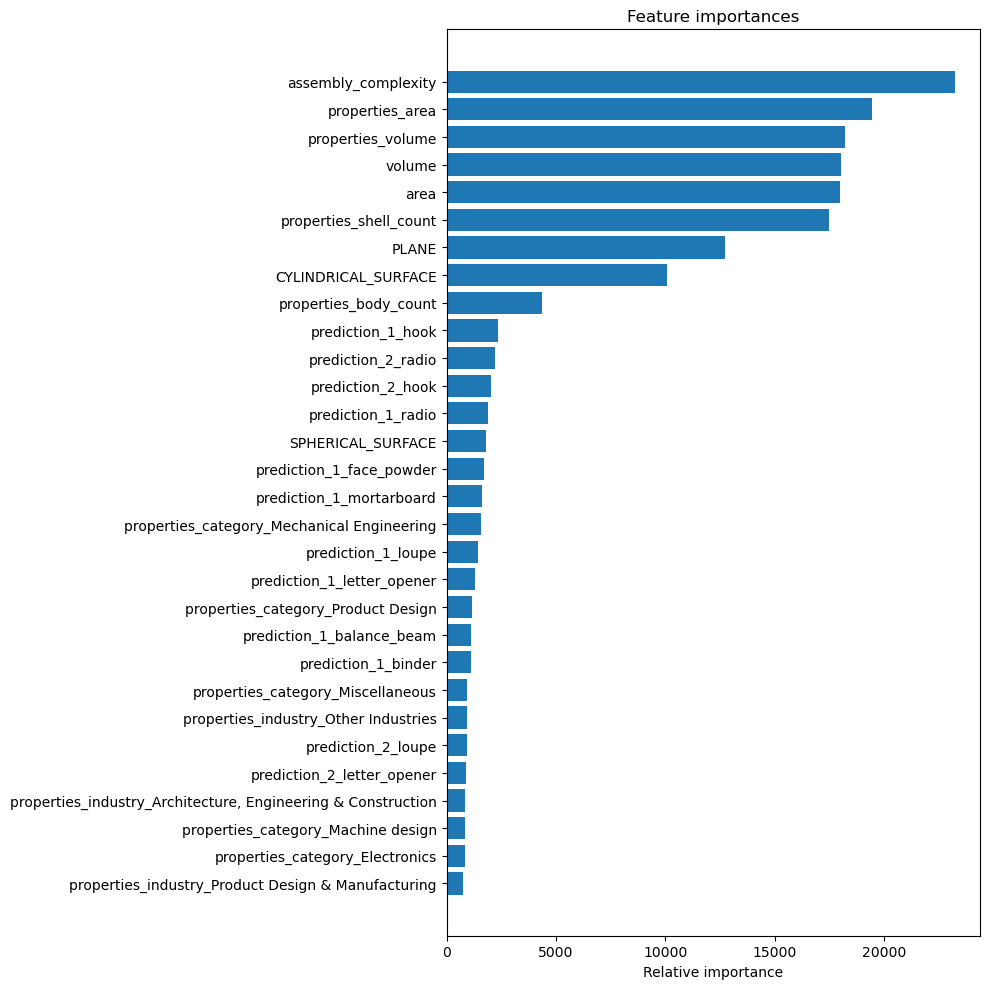

In [221]:
# Load the trained LGBM pipeline
loaded_pipeline = load("lgbm_model.pkl")

# Extract the LGBM classifier from the pipeline
clf = loaded_pipeline.named_steps['classifier']

# Get feature names from the preprocessor
feature_names = get_transformer_feature_names(loaded_pipeline.named_steps['preprocessor'])

# Get feature importances
importances = clf.feature_importances_

# Sort the features by importance
sorted_indices = np.argsort(importances)[::-1]

# Plotting the top N feature importances
N = 30  # you can change this value to display more or less features
plt.figure(figsize=(10, 10))
plt.title("Feature importances")
plt.barh(range(N), importances[sorted_indices][:N][::-1], align="center")
plt.yticks(range(N), [feature_names[i] for i in sorted_indices][:N][::-1])
plt.xlabel("Relative importance")
plt.tight_layout()
plt.show()

In [222]:
df_test_main.shape

(155, 53)

In [223]:
df_test_main.head()

,material_category,volume,area,assembly_complexity,properties_shell_count,properties_body_count,properties_area,properties_volume,properties_category_Mechanical Engineering,properties_category_Product Design,properties_category_Miscellaneous,properties_category_Electronics,properties_category_Machine design,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,properties_industry_Other Industries,"properties_industry_Architecture, Engineering & Construction",properties_industry_Product Design & Manufacturing,properties_industry_Civil Infrastructure,properties_industry_Media & Entertainment,body_file_size,CYLINDRICAL_SURFACE,SPHERICAL_SURFACE,PLANE,prediction_1_balance_beam,prediction_1_hook,prediction_1_letter_opener,prediction_1_mortarboard,prediction_1_radio,prediction_1_face_powder,prediction_1_ping-pong_ball,prediction_1_binder,prediction_1_loupe,prediction_1_broom,prediction_1_screw,prediction_1_coil,prediction_2_letter_opener,prediction_2_hook,prediction_2_radio,prediction_2_binder,prediction_2_switch,prediction_2_loupe,prediction_2_envelope,prediction_2_loudspeaker,prediction_2_maraca,prediction_2_academic_gown,prediction_2_screw,prediction_2_coil,name_cluster,comp_name_cluster
0,None,1.089020,7.679887,575508024,7,7,2191.649089,1225.585809,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,39531,1,0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,None,475.446755,972.513358,575508024,7,7,2191.649089,1225.585809,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,777582,39,8,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.221041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,None,241.470603,460.819725,575508024,7,7,2191.649089,1225.585809,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1075824,81,0,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,None,21.600000,73.200000,575508024,7,7,2191.649089,1225.585809,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,11328,0,0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,None,11.563476,54.622106,575508024,7,7,2191.649089,1225.585809,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,37176,12,4,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [224]:
y_test_old = pd.read_pickle('df_y_test_old.pkl')

In [225]:
# Dropping categorical columns from the test dataframe
df_test_main = df_test_main_com.drop(columns=['body_id', 'assembly_id', 'name', 'components_name'])

# Extracting feature matrix and target variable from the modified test dataframe
X_test_main = df_test_main[columns_for_ml] # It's safer to use errors='ignore' just in case the column was already dropped.
# .drop(columns=['material_category'], errors='ignore') 
y_test_main = df_test_main['material_category']

most_frequent_label = y_train.mode()[0]
y_test_main.fillna(most_frequent_label, inplace=True)


# Now, using the LGBM model for testing
classifiers = [
    ("LGBM", LGBMClassifier(random_state=42))
]

results = {}
for name, _ in classifiers:
    model_path = f"{name.replace(' ', '_').lower()}_model.pkl"
    try:
        # Load the entire pipeline
        loaded_pipeline = load(model_path)
        
        # Predict using the loaded pipeline directly
        y_pred = loaded_pipeline.predict(X_test_main)

        results[name] = {
            'accuracy': accuracy_score(y_test_old, y_pred),
            'precision': precision_score(y_test_old, y_pred, average='weighted'),
            'recall': recall_score(y_test_old, y_pred, average='weighted'),
            'f1': f1_score(y_test_old, y_pred, average='weighted')
        }
        print(f"{name} evaluation completed successfully.")
    except Exception as e:
        results[name] = str(e)
        print(f"Error during {name} evaluation: {e}")

# Display results in a structured manner
if results:
    if isinstance(list(results.values())[0], dict):  # Check if results contain metrics
        print(pd.DataFrame(results).T)
    else:  # If results contain error messages
        for model, error in results.items():
            print(f"{model} Error: {error}")

# Sample and display ten labels of y_true and y_pred
sample_indices = y_test_old.sample(100).index
y_true_sample = y_test_old[sample_indices]
y_pred_sample = [y_pred[i] for i in sample_indices]

comparison_df = pd.DataFrame({
    'True Labels': y_true_sample,
    'Predicted Labels': y_pred_sample
})

comparison_df.head(15)

LGBM evaluation completed successfully.
      accuracy        f1  precision    recall
LGBM  0.335484  0.326458   0.409636  0.335484


,True Labels,Predicted Labels
19,Metal_Ferrous_Steel,Plastic
94,Metal_Ferrous_Steel,Other
80,Metal_Ferrous_Steel,Other
30,Metal_Ferrous_Steel,Metal_Non-Ferrous
135,Plastic,Metal_Ferrous_Steel
90,Metal_Ferrous_Steel,Metal_Ferrous_Steel
26,Metal_Non-Ferrous,Metal_Ferrous_Steel
79,Metal_Non-Ferrous,Metal_Ferrous_Steel
29,Metal_Non-Ferrous,Metal_Non-Ferrous
105,Wood,Wood


In [226]:
# Using the best model (LGBM in this case) to predict
# Load the trained pipeline for LGBM
loaded_pipeline = load("lgbm_model_0556.pkl")

# Predicting the material_category for the test set
predicted_material_category = loaded_pipeline.predict(df_test_main.drop(columns=['material_category'], errors='ignore'))

# Creating the submission dataframe
submission_df = df_test_main_com[['assembly_id', 'body_id']].copy()  # Using df_test_main_com to ensure the original order is preserved
submission_df['material_category'] = predicted_material_category

# Save the dataframe to submission.csv
submission_df.to_csv('submission_Team_Voldemort.csv', index=False)

print("submission.csv has been saved!")

FileNotFoundError: [Errno 2] No such file or directory: 'lgbm_model_0556.pkl'